In [1]:
!pip install kmapper gudhi
!git clone https://github.com/MLWave/kepler-mapper
%cd kepler-mapper
!pip install -e .
%cd ..

fatal: destination path 'kepler-mapper' already exists and is not an empty directory.
/content/kepler-mapper
Obtaining file:///content/kepler-mapper
  Preparing metadata (setup.py) ... done
  Attempting uninstall: kmapper
    Found existing installation: kmapper 2.0.1
    Uninstalling kmapper-2.0.1:
      Successfully uninstalled kmapper-2.0.1
  Running setup.py develop for kmapper
/content


*Note: restart session after finish installing*

## Data Preparation

In [2]:
import io
import os
import numpy
def patch_asscalar(a):
    return a.item()

setattr(numpy, "asscalar", patch_asscalar)

import sklearn
import numpy as np
import kmapper as km
import gudhi as gd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import cluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from gudhi import SimplexTree, plot_persistence_diagram
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from tqdm.notebook import tqdm

In [3]:
language_map = {
    "af": "Afrikaans",
    "ar": "Arabic",
    "bg": "Bulgarian",
    "bn": "Bengali",
    "bs": "Bosnian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "en": "English",
    "es": "Spanish",
    "et": "Estonian",
    "fa": "Persian",
    "fi": "Finnish",
    "fr": "French",
    "he": "Hebrew",
    "hi": "Hindi",
    "hr": "Croatian",
    "hu": "Hungarian",
    "id": "Indonesian",
    "it": "Italian",
    "ko": "Korean",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "mk": "Macedonian",
    "ms": "Malay",
    "nl": "Dutch",
    "no": "Norwegian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "sq": "Albanian",
    "sv": "Swedish",
    "ta": "Tamil",
    "th": "Thai",
    "tl": "Tagalog",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
    "zh": "Chinese"
}

In [4]:
!rm ./*.align.vec

rm: cannot remove './*.align.vec': No such file or directory


## Mapper Visualization & Building Persistence Diagram

In [5]:
def load_vectors(fname, samp_num=1000):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = []
    words = []
    for line in fin:
        tokens = line.rstrip().split(' ')
        if len(data)==0:
            data = np.array([tokens[1:]]).astype(np.float32)
            print(data.shape)
        else:
            data = np.append(data, np.array([tokens[1:]]).astype(np.float32), axis=0)
        words.append(tokens[0])
        if len(data) == samp_num:
            break
    return data, words

In [6]:
os.chdir('/content/')
pd_dict = dict()

for abbr in tqdm(language_map):
    if not os.path.exists(f'wiki.{abbr}.align.vec'):
        !wget https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.{abbr}.align.vec

    arr, words = load_vectors(f'wiki.{abbr}.align.vec', samp_num=1000)
    labels = np.array(words)
    mapper = km.KeplerMapper(verbose=1)
    lens = mapper.fit_transform(arr, projection="knn_distance_5")
    scomplex = mapper.map(lens,
                        arr,
                        clusterer=cluster.AgglomerativeClustering(n_clusters=3,
                                                                    linkage="complete",
                                                                    affinity="cosine"),
                        cover=km.Cover(n_cubes=15, perc_overlap=0.2))

    mapper.visualize(scomplex, custom_tooltips=labels,
                     path_html=f"{abbr}-topo.html", title=f"{language_map[abbr]} Topology")

    st = SimplexTree()

    node_mapping = {node: idx for idx, node in enumerate(scomplex['nodes'])}

    for node in scomplex['nodes']:
        node_idx = node_mapping[node]
        st.insert([node_idx], filtration=1)

    for node, links in scomplex['links'].items():
        node_idx = node_mapping[node]
        for link in links:
            link_idx = node_mapping[link]
            if not st.insert([node_idx, link_idx], filtration=1):
                print(f"Failed to insert link between {node_idx} and {link_idx}")

    for node, elements in scomplex['nodes'].items():
        node_idx = node_mapping[node]
        if st.find([node_idx]):
            st.assign_filtration([node_idx], filtration=len(elements))
        else:
            print(f"Node {node_idx} not found in SimplexTree")

    st.make_filtration_non_decreasing()
    st.persistence(persistence_dim_max=True)
    pd = st.persistence_intervals_in_dimension(0)
    pd_dict[abbr] = pd

    # delete file to save space
    os.remove(f'wiki.{abbr}.align.vec')

  0%|          | 0/44 [00:00<?, ?it/s]

--2024-06-11 23:48:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.af.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.34, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217061331 (207M) [binary/octet-stream]
Saving to: ‘wiki.af.align.vec’

wiki.af.align.vec   100%[===================>] 207.00M  50.6MB/s    in 3.7s    

2024-06-11 23:48:52 (55.7 MB/s) - ‘wiki.af.align.vec’ saved [217061331/217061331]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be


Created 49 edges and 39 nodes in 0:00:00.586681.
Wrote visualization to: af-topo.html
--2024-06-11 23:48:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.ar.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.34, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1383879814 (1.3G) [binary/octet-stream]
Saving to: ‘wiki.ar.align.vec’

wiki.ar.align.vec   100%[===================>]   1.29G  50.5MB/s    in 33s     

2024-06-11 23:49:31 (40.3 MB/s) - ‘wiki.ar.align.vec’ saved [1383879814/1383879814]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens sh

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: ar-topo.html
--2024-06-11 23:49:33--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.bg.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 757050634 (722M) [binary/octet-stream]
Saving to: ‘wiki.bg.align.vec’

wiki.bg.align.vec   100%[===================>] 721.98M  47.6MB/s    in 8.5s    

2024-06-11 23:49:41 (84.8 MB/s) - ‘wiki.bg.align.vec’ saved [757050634/757050634]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 60 e

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: bg-topo.html
--2024-06-11 23:49:42--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.bn.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 329969670 (315M) [binary/octet-stream]
Saving to: ‘wiki.bn.align.vec’

wiki.bn.align.vec   100%[===================>] 314.68M   148MB/s    in 2.1s    

2024-06-11 23:49:44 (148 MB/s) - ‘wiki.bn.align.vec’ saved [329969670/329969670]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be


Created 49 edges and 45 nodes in 0:00:00.087375.
Wrote visualization to: bn-topo.html
--2024-06-11 23:49:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.bs.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 376090435 (359M) [binary/octet-stream]
Saving to: ‘wiki.bs.align.vec’

wiki.bs.align.vec   100%[===================>] 358.67M  99.2MB/s    in 3.6s    

2024-06-11 23:49:50 (99.6 MB/s) - ‘wiki.bs.align.vec’ saved [376090435/376090435]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: bs-topo.html
--2024-06-11 23:49:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.ca.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1108018880 (1.0G) [binary/octet-stream]
Saving to: ‘wiki.ca.align.vec’

wiki.ca.align.vec   100%[===================>]   1.03G  76.0MB/s    in 14s     

2024-06-11 23:50:05 (73.9 MB/s) - ‘wiki.ca.align.vec’ saved [1108018880/1108018880]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: ca-topo.html
--2024-06-11 23:50:08--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.cs.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.11, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1418982255 (1.3G) [binary/octet-stream]
Saving to: ‘wiki.cs.align.vec’

wiki.cs.align.vec   100%[===================>]   1.32G   140MB/s    in 14s     

2024-06-11 23:50:22 (96.6 MB/s) - ‘wiki.cs.align.vec’ saved [1418982255/1418982255]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: cs-topo.html
--2024-06-11 23:50:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.da.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.11, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707717437 (675M) [binary/octet-stream]
Saving to: ‘wiki.da.align.vec’

wiki.da.align.vec   100%[===================>] 674.93M  90.7MB/s    in 7.9s    

2024-06-11 23:50:31 (85.9 MB/s) - ‘wiki.da.align.vec’ saved [707717437/707717437]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be


Created 62 edges and 42 nodes in 0:00:00.106185.
Wrote visualization to: da-topo.html
--2024-06-11 23:50:32--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.de.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.11, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5147085911 (4.8G) [binary/octet-stream]
Saving to: ‘wiki.de.align.vec’

wiki.de.align.vec   100%[===================>]   4.79G  80.3MB/s    in 56s     

2024-06-11 23:51:28 (88.3 MB/s) - ‘wiki.de.align.vec’ saved [5147085911/5147085911]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens sh

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: de-topo.html
--2024-06-11 23:51:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.el.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694764422 (663M) [binary/octet-stream]
Saving to: ‘wiki.el.align.vec’

wiki.el.align.vec   100%[===================>] 662.58M  52.0MB/s    in 6.7s    

2024-06-11 23:51:36 (98.4 MB/s) - ‘wiki.el.align.vec’ saved [694764422/694764422]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 59 e

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: el-topo.html
--2024-06-11 23:51:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.en.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5685446378 (5.3G) [binary/octet-stream]
Saving to: ‘wiki.en.align.vec’

wiki.en.align.vec   100%[===================>]   5.29G  87.8MB/s    in 44s     

2024-06-11 23:52:22 (122 MB/s) - ‘wiki.en.align.vec’ saved [5685446378/5685446378]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 49

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: en-topo.html
--2024-06-11 23:52:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.es.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2227283009 (2.1G) [binary/octet-stream]
Saving to: ‘wiki.es.align.vec’

wiki.es.align.vec   100%[===================>]   2.07G  84.8MB/s    in 22s     

2024-06-11 23:52:47 (94.9 MB/s) - ‘wiki.es.align.vec’ saved [2227283009/2227283009]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: es-topo.html
--2024-06-11 23:52:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.et.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 746950350 (712M) [binary/octet-stream]
Saving to: ‘wiki.et.align.vec’

wiki.et.align.vec   100%[===================>] 712.35M   108MB/s    in 6.4s    

2024-06-11 23:52:54 (112 MB/s) - ‘wiki.et.align.vec’ saved [746950350/746950350]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 72 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: et-topo.html
--2024-06-11 23:52:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.fa.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 950255668 (906M) [binary/octet-stream]
Saving to: ‘wiki.fa.align.vec’

wiki.fa.align.vec   100%[===================>] 906.23M   210MB/s    in 5.1s    

2024-06-11 23:53:00 (179 MB/s) - ‘wiki.fa.align.vec’ saved [950255668/950255668]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 60 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: fa-topo.html
--2024-06-11 23:53:01--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.fi.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1654014766 (1.5G) [binary/octet-stream]
Saving to: ‘wiki.fi.align.vec’

wiki.fi.align.vec   100%[===================>]   1.54G   172MB/s    in 15s     

2024-06-11 23:53:16 (103 MB/s) - ‘wiki.fi.align.vec’ saved [1654014766/1654014766]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 55

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: fi-topo.html
--2024-06-11 23:53:17--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.fr.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2605241176 (2.4G) [binary/octet-stream]
Saving to: ‘wiki.fr.align.vec’

wiki.fr.align.vec   100%[===================>]   2.43G  46.7MB/s    in 25s     

2024-06-11 23:53:43 (99.0 MB/s) - ‘wiki.fr.align.vec’ saved [2605241176/2605241176]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: fr-topo.html
--2024-06-11 23:53:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.he.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1106836660 (1.0G) [binary/octet-stream]
Saving to: ‘wiki.he.align.vec’

wiki.he.align.vec   100%[===================>]   1.03G   219MB/s    in 6.6s    

2024-06-11 23:53:50 (159 MB/s) - ‘wiki.he.align.vec’ saved [1106836660/1106836660]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 50

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: he-topo.html
--2024-06-11 23:53:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.hi.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358325821 (342M) [binary/octet-stream]
Saving to: ‘wiki.hi.align.vec’

wiki.hi.align.vec   100%[===================>] 341.73M   212MB/s    in 1.6s    

2024-06-11 23:53:53 (212 MB/s) - ‘wiki.hi.align.vec’ saved [358325821/358325821]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 65 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: hi-topo.html
--2024-06-11 23:53:54--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.hr.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1020015243 (973M) [binary/octet-stream]
Saving to: ‘wiki.hr.align.vec’

wiki.hr.align.vec   100%[===================>] 972.76M   189MB/s    in 4.9s    

2024-06-11 23:53:59 (200 MB/s) - ‘wiki.hr.align.vec’ saved [1020015243/1020015243]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 54

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: hr-topo.html
--2024-06-11 23:54:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.hu.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1796153393 (1.7G) [binary/octet-stream]
Saving to: ‘wiki.hu.align.vec’

wiki.hu.align.vec   100%[===================>]   1.67G  93.6MB/s    in 17s     

2024-06-11 23:54:17 (103 MB/s) - ‘wiki.hu.align.vec’ saved [1796153393/1796153393]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 56

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: hu-topo.html
--2024-06-11 23:54:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.id.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.34, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 679060758 (648M) [binary/octet-stream]
Saving to: ‘wiki.id.align.vec’

wiki.id.align.vec   100%[===================>] 647.60M   198MB/s    in 3.4s    

2024-06-11 23:54:21 (192 MB/s) - ‘wiki.id.align.vec’ saved [679060758/679060758]

(1, 300)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: id-topo.html
--2024-06-11 23:54:22--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.it.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.34, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1968769722 (1.8G) [binary/octet-stream]
Saving to: ‘wiki.it.align.vec’

wiki.it.align.vec   100%[===================>]   1.83G   174MB/s    in 21s     

2024-06-11 23:54:43 (90.6 MB/s) - ‘wiki.it.align.vec’ saved [1968769722/1968769722]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be


Created 50 edges and 45 nodes in 0:00:00.110566.
Wrote visualization to: it-topo.html
--2024-06-11 23:54:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.ko.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.34, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1989728101 (1.9G) [binary/octet-stream]
Saving to: ‘wiki.ko.align.vec’

wiki.ko.align.vec   100%[===================>]   1.85G   181MB/s    in 14s     

2024-06-11 23:54:58 (140 MB/s) - ‘wiki.ko.align.vec’ saved [1989728101/1989728101]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens sha

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: ko-topo.html
--2024-06-11 23:55:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.lt.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 693148615 (661M) [binary/octet-stream]
Saving to: ‘wiki.lt.align.vec’

wiki.lt.align.vec   100%[===================>] 661.04M   161MB/s    in 4.2s    

2024-06-11 23:55:04 (159 MB/s) - ‘wiki.lt.align.vec’ saved [693148615/693148615]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 70 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: lt-topo.html
--2024-06-11 23:55:06--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.lv.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386622061 (369M) [binary/octet-stream]
Saving to: ‘wiki.lv.align.vec’

wiki.lv.align.vec   100%[===================>] 368.71M  42.1MB/s    in 6.9s    

2024-06-11 23:55:13 (53.1 MB/s) - ‘wiki.lv.align.vec’ saved [386622061/386622061]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 58 e

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: lv-topo.html
--2024-06-11 23:55:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.mk.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401196351 (383M) [binary/octet-stream]
Saving to: ‘wiki.mk.align.vec’

wiki.mk.align.vec   100%[===================>] 382.61M   166MB/s    in 2.3s    

2024-06-11 23:55:16 (166 MB/s) - ‘wiki.mk.align.vec’ saved [401196351/401196351]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 76 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: mk-topo.html
--2024-06-11 23:55:19--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.ms.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 351471985 (335M) [binary/octet-stream]
Saving to: ‘wiki.ms.align.vec’

wiki.ms.align.vec   100%[===================>] 335.19M   126MB/s    in 2.7s    

2024-06-11 23:55:22 (126 MB/s) - ‘wiki.ms.align.vec’ saved [351471985/351471985]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 56 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: ms-topo.html
--2024-06-11 23:55:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.nl.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1969330444 (1.8G) [binary/octet-stream]
Saving to: ‘wiki.nl.align.vec’

wiki.nl.align.vec    97%[==================> ]   1.79G   125MB/s    eta 0s     (1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 52 edges and 45 nodes in 0:00:00.116765.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: nl-topo.html
--2024-06-11 23:55:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.no.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1166615802 (1.1G) [binary/octet-stream]
Saving to: ‘wiki.no.align.vec’

wiki.no.align.vec   100%[===================>]   1.09G   219MB/s    in 8.4s    

2024-06-11 23:55:46 (132 MB/s) - ‘wiki.no.align.vec’ saved [1166615802/1166615802]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 53

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: no-topo.html
--2024-06-11 23:55:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.pl.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2334561173 (2.2G) [binary/octet-stream]
Saving to: ‘wiki.pl.align.vec’

wiki.pl.align.vec   100%[===================>]   2.17G  97.7MB/s    in 26s     

2024-06-11 23:56:13 (84.6 MB/s) - ‘wiki.pl.align.vec’ saved [2334561173/2334561173]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: pl-topo.html
--2024-06-11 23:56:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.pt.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1338109461 (1.2G) [binary/octet-stream]
Saving to: ‘wiki.pt.align.vec’

wiki.pt.align.vec   100%[===================>]   1.25G   100MB/s    in 12s     

2024-06-11 23:56:26 (111 MB/s) - ‘wiki.pt.align.vec’ saved [1338109461/1338109461]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 50

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: pt-topo.html
--2024-06-11 23:56:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.ro.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800754304 (764M) [binary/octet-stream]
Saving to: ‘wiki.ro.align.vec’

wiki.ro.align.vec   100%[===================>] 763.66M   211MB/s    in 3.7s    

2024-06-11 23:56:31 (204 MB/s) - ‘wiki.ro.align.vec’ saved [800754304/800754304]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 58 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: ro-topo.html
--2024-06-11 23:56:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.ru.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4284700660 (4.0G) [binary/octet-stream]
Saving to: ‘wiki.ru.align.vec’

wiki.ru.align.vec   100%[===================>]   3.99G  73.6MB/s    in 46s     

2024-06-11 23:57:17 (89.6 MB/s) - ‘wiki.ru.align.vec’ saved [4284700660/4284700660]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: ru-topo.html
--2024-06-11 23:57:19--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.sk.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 714486546 (681M) [binary/octet-stream]
Saving to: ‘wiki.sk.align.vec’

wiki.sk.align.vec   100%[===================>] 681.39M   190MB/s    in 3.7s    

2024-06-11 23:57:23 (185 MB/s) - ‘wiki.sk.align.vec’ saved [714486546/714486546]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 60 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: sk-topo.html
--2024-06-11 23:57:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.sl.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 636569329 (607M) [binary/octet-stream]
Saving to: ‘wiki.sl.align.vec’

wiki.sl.align.vec   100%[===================>] 607.08M  64.0MB/s    in 6.8s    

2024-06-11 23:57:30 (89.5 MB/s) - ‘wiki.sl.align.vec’ saved [636569329/636569329]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 62 e

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: sl-topo.html
--2024-06-11 23:57:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.sq.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315257412 (301M) [binary/octet-stream]
Saving to: ‘wiki.sq.align.vec’

wiki.sq.align.vec   100%[===================>] 300.65M   161MB/s    in 1.9s    

2024-06-11 23:57:33 (161 MB/s) - ‘wiki.sq.align.vec’ saved [315257412/315257412]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 48 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: sq-topo.html
--2024-06-11 23:57:34--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.sv.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2584087604 (2.4G) [binary/octet-stream]
Saving to: ‘wiki.sv.align.vec’

wiki.sv.align.vec   100%[===================>]   2.41G   228MB/s    in 27s     

2024-06-11 23:58:01 (91.0 MB/s) - ‘wiki.sv.align.vec’ saved [2584087604/2584087604]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 6

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: sv-topo.html
--2024-06-11 23:58:03--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.ta.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.34, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 559430049 (534M) [binary/octet-stream]
Saving to: ‘wiki.ta.align.vec’

wiki.ta.align.vec   100%[===================>] 533.51M   213MB/s    in 2.5s    

2024-06-11 23:58:05 (213 MB/s) - ‘wiki.ta.align.vec’ saved [559430049/559430049]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 64 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: ta-topo.html
--2024-06-11 23:58:06--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.th.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.34, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243654384 (232M) [binary/octet-stream]
Saving to: ‘wiki.th.align.vec’

wiki.th.align.vec   100%[===================>] 232.37M   157MB/s    in 1.5s    

2024-06-11 23:58:08 (157 MB/s) - ‘wiki.th.align.vec’ saved [243654384/243654384]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 32 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: th-topo.html
--2024-06-11 23:58:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.tl.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.34, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150799472 (144M) [binary/octet-stream]
Saving to: ‘wiki.tl.align.vec’

wiki.tl.align.vec   100%[===================>] 143.81M   162MB/s    in 0.9s    

2024-06-11 23:58:10 (162 MB/s) - ‘wiki.tl.align.vec’ saved [150799472/150799472]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be


Created 62 edges and 33 nodes in 0:00:00.107050.
Wrote visualization to: tl-topo.html
--2024-06-11 23:58:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.tr.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.34, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 940853979 (897M) [binary/octet-stream]
Saving to: ‘wiki.tr.align.vec’

wiki.tr.align.vec   100%[===================>] 897.27M   131MB/s    in 6.6s    

2024-06-11 23:58:17 (137 MB/s) - ‘wiki.tr.align.vec’ saved [940853979/940853979]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: tr-topo.html
--2024-06-11 23:58:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.uk.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.34, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2069121752 (1.9G) [binary/octet-stream]
Saving to: ‘wiki.uk.align.vec’

wiki.uk.align.vec   100%[===================>]   1.93G  72.9MB/s    in 24s     

2024-06-11 23:58:42 (84.0 MB/s) - ‘wiki.uk.align.vec’ saved [2069121752/2069121752]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 6

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: uk-topo.html
--2024-06-11 23:58:43--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.vi.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.34, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 659623425 (629M) [binary/octet-stream]
Saving to: ‘wiki.vi.align.vec’

wiki.vi.align.vec   100%[===================>] 629.07M   108MB/s    in 5.4s    

2024-06-11 23:58:48 (116 MB/s) - ‘wiki.vi.align.vec’ saved [659623425/659623425]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 42 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: vi-topo.html
--2024-06-11 23:58:50--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.zh.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.34, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 750904087 (716M) [binary/octet-stream]
Saving to: ‘wiki.zh.align.vec’

wiki.zh.align.vec   100%[===================>] 716.12M   203MB/s    in 3.6s    

2024-06-11 23:58:53 (199 MB/s) - ‘wiki.zh.align.vec’ saved [750904087/750904087]

(1, 300)
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 300)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 300) using lens shaped (1000, 1)

Creating 15 hypercubes.

Created 40 ed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Wrote visualization to: zh-topo.html


## Calculating Pairwise Bottleneck Distance Matrix

In [7]:
pds = list(pd_dict.values())

# modify the inf(death time) points
finite_pds = [[(birth, death) for birth, death in i  if np.isfinite(death)] for i in pds]

num_pd = len(finite_pds)
distance_matrix = np.zeros((num_pd, num_pd))

for i in range(num_pd):
    for j in range(i + 1, num_pd):
        d = gd.bottleneck_distance(finite_pds[i], finite_pds[j])
        distance_matrix[i, j] = distance_matrix[j, i] = d

## Hierarchical Clustering

In [10]:
condensed_distance_matrix = squareform(distance_matrix)
linked = linkage(condensed_distance_matrix, method='ward', optimal_ordering=True)

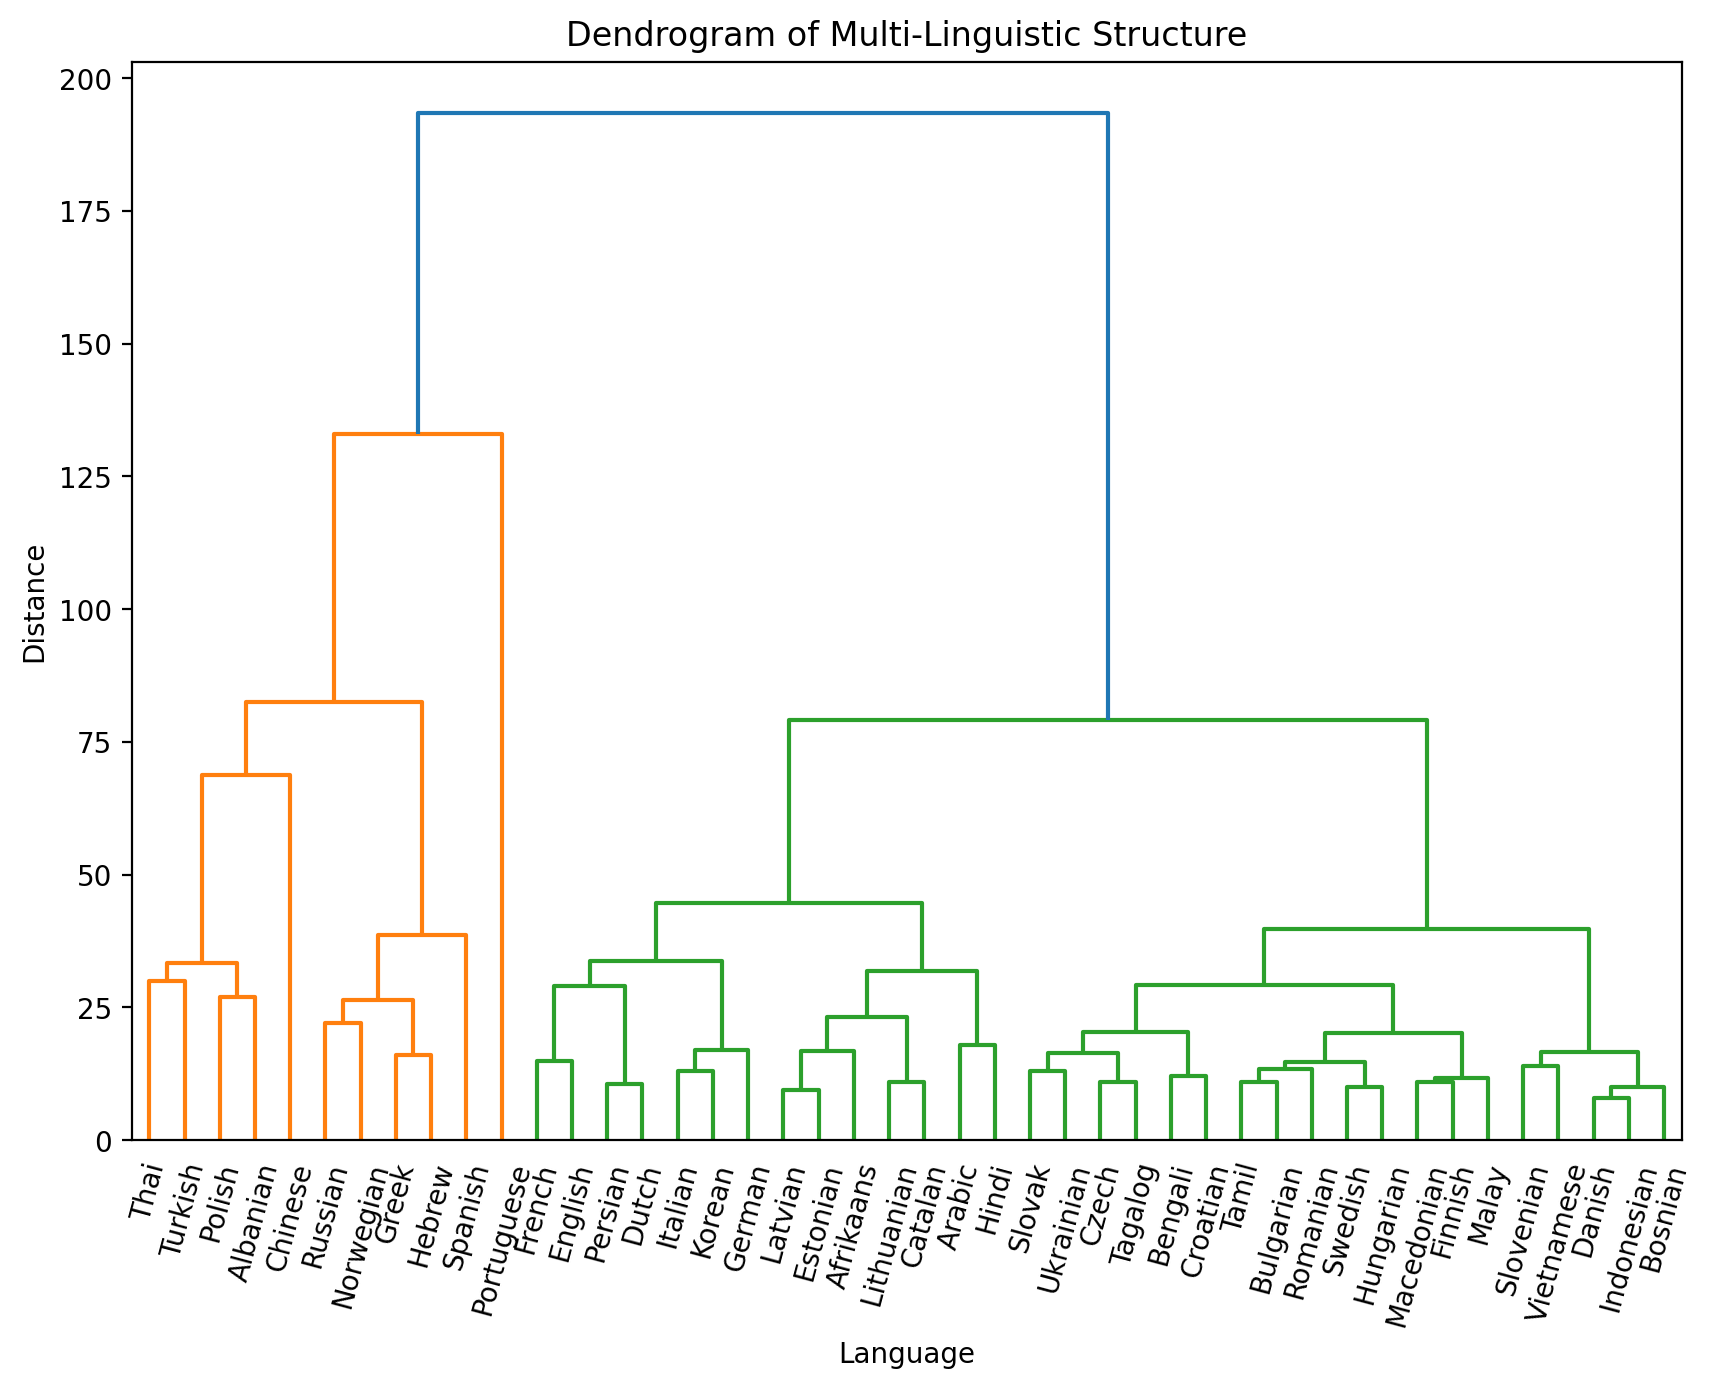

In [13]:
plt.figure(figsize=(10, 7), dpi=200)
dendrogram(linked,
           labels=[language_map[key] for key in language_map],
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Multi-Linguistic Structure')
plt.xlabel('Language')
# plt.axhline(y=50, color='red', linestyle='--')
# plt.axhline(y=35, color='brown', linestyle='--')
# plt.axhline(y=25, color='black', linestyle='--')
plt.xticks(rotation=75, rotation_mode="default", fontsize=10)
plt.ylabel('Distance')
plt.show()